In [13]:
import json
import pandas as pd
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping

### **1. Chuẩn bị dữ liệu cho mô hình**

In [14]:
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def prepare_data(data):
    prepared_data = []
    dialog_groups = {}
    for entry in data:
        dialog_id = entry[0]
        if dialog_id not in dialog_groups:
            dialog_groups[dialog_id] = []
        dialog_groups[dialog_id].append(entry)

    for dialog_id, turns in dialog_groups.items():
        context = []
        for turn in turns:
            speaker = turn[2]
            text = turn[3]
            dialog_act = turn[4]["dialog_act"]
            # Chỉ xét câu của USER
            if speaker == "USER":
                acts = list(dialog_act.keys())
                prepared_data.append({
                    "dialog_id": dialog_id,
                    "context": context[:],  
                    "current_utterance": text,
                    "label": acts
                })
            context.append(f"{speaker}: {text}")

    return prepared_data

In [15]:
def save_to_csv(processed_data, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Dialog_ID', 'Context', 'Current_Utterance', 'Labels'])
        for entry in processed_data:
            writer.writerow([
                entry['dialog_id'],
                ' | '.join(entry['context']),
                entry['current_utterance'],
                '|'.join(entry['label'])       
            ])

train_data = load_json_data('/kaggle/input/data-v2/train_xy2.json')
val_data = load_json_data('/kaggle/input/data-v2/val_xy2.json')
test_data = load_json_data('/kaggle/input/data-v2/test_xy2.json')

train_processed = prepare_data(train_data)
val_processed = prepare_data(val_data)
test_processed = prepare_data(test_data)

save_to_csv(train_processed, '/kaggle/working/train_processed.csv')
save_to_csv(val_processed, '/kaggle/working/val_processed.csv')
save_to_csv(test_processed, '/kaggle/working/test_processed.csv')

In [16]:
train_df = pd.read_csv('/kaggle/working/train_processed.csv')
val_df = pd.read_csv('/kaggle/working/val_processed.csv')
test_df = pd.read_csv('/kaggle/working/test_processed.csv')

# Kết hợp Context và Current_Utterance để tạo full_input
train_df['full_input'] = train_df['Context'].fillna('') + ' ' + train_df['Current_Utterance'].fillna('')
val_df['full_input'] = val_df['Context'].fillna('') + ' ' + val_df['Current_Utterance'].fillna('')
test_df['full_input'] = test_df['Context'].fillna('') + ' ' + test_df['Current_Utterance'].fillna('')

train_df['Labels'] = train_df['Labels'].fillna('').str.split('|')
val_df['Labels'] = val_df['Labels'].fillna('').str.split('|')
test_df['Labels'] = test_df['Labels'].fillna('').str.split('|')

unique_labels = pd.Series(train_df['Labels'].explode()).unique()

# Tạo cột one-hot cho từng nhãn
for label in unique_labels:
    train_df[label] = train_df['Labels'].apply(lambda x: 1 if label in x else 0)
    val_df[label] = val_df['Labels'].apply(lambda x: 1 if label in x else 0)
    test_df[label] = test_df['Labels'].apply(lambda x: 1 if label in x else 0)

In [17]:
X_train = train_df["full_input"].values
y_train = train_df[unique_labels].values
X_val = val_df["full_input"].values
y_val = val_df[unique_labels].values
X_test = test_df["full_input"].values
y_test = test_df[unique_labels].values

# Tokenize và Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_tokenized)
X_train_padded = pad_sequences(X_train_tokenized, padding='post', maxlen=max_len)
X_val_padded = pad_sequences(X_val_tokenized, padding='post', maxlen=max_len)
X_test_padded = pad_sequences(X_test_tokenized, padding='post', maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

### **2. Xây dựng mô hình**

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(len(unique_labels), activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train, epochs=100, batch_size=32,callbacks=[early_stopping], validation_data=(X_val_padded, y_val))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.4179 - loss: 0.1904 - val_accuracy: 0.7758 - val_loss: 0.0796
Epoch 2/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8173 - loss: 0.0678 - val_accuracy: 0.8541 - val_loss: 0.0510
Epoch 3/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8736 - loss: 0.0456 - val_accuracy: 0.8742 - val_loss: 0.0421
Epoch 4/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.8953 - loss: 0.0362 - val_accuracy: 0.8811 - val_loss: 0.0384
Epoch 5/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.9017 - loss: 0.0317 - val_accuracy: 0.8926 - val_loss: 0.0360
Epoch 6/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.9042 - loss: 0.0298 - val_accuracy: 0.8908 - val_loss: 0.0356
Epoch 7/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.9116 - loss: 0.0266 - val_accuracy: 0.8953 - val_loss: 0.0343
Epoch 8/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 

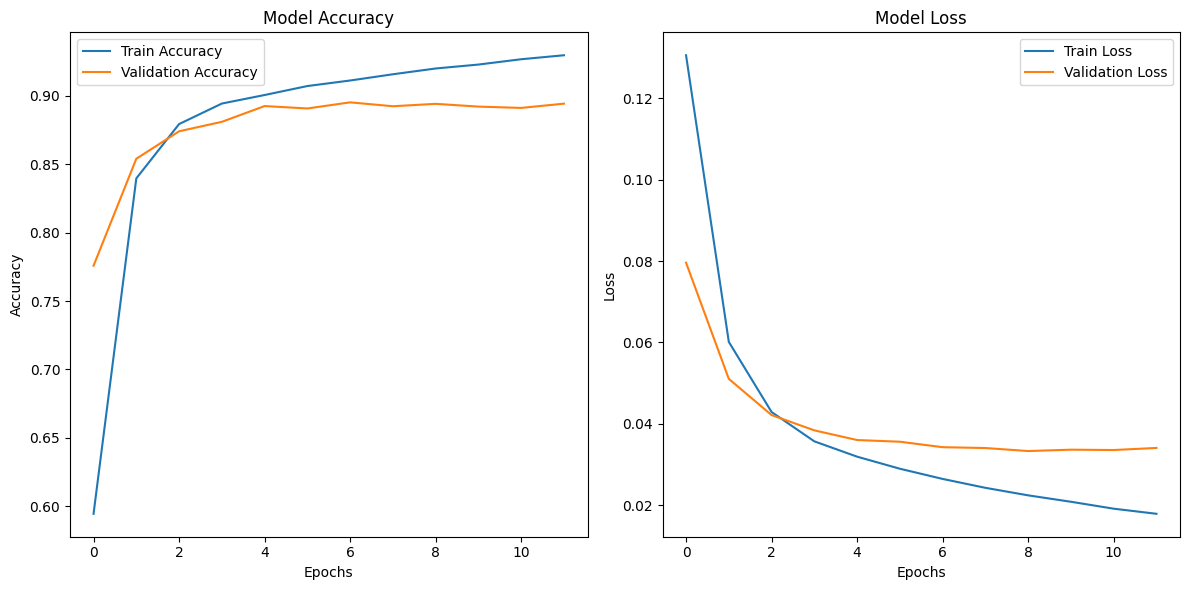

In [19]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### **3. Đánh giá mô hình trên tập test**

In [20]:
y_pred = model.predict(X_test_padded)

y_pred_bin = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_bin)
precision = precision_score(y_test, y_pred_bin, average='micro')
recall = recall_score(y_test, y_pred_bin, average='micro')
f1 = f1_score(y_test, y_pred_bin, average='micro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Accuracy: 0.8619099294628323
Precision: 0.9265363485371151
Recall: 0.8977469670710572
F1 Score: 0.9119144922980195


### **4. Lưu lại mô hình đã huấn luyện**

In [21]:
from tensorflow.keras.models import save_model

model.save('/kaggle/working/trained_model_context.h5')
print("Model saved to /kaggle/working/trained_model_context.h5")

Model saved to /kaggle/working/trained_model_context.h5


In [22]:
import pickle
with open('/kaggle/working/tokenizer_context.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('metadata.json', 'w') as f:
    json.dump({
        'unique_labels': unique_labels.tolist(),
        'max_len': max_len
    }, f)

### **5. Sử dụng mô hình đã lưu đưa ra dự đoán**

In [23]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/trained_model_context.h5')


In [24]:
import pickle

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('metadata.json', 'r') as f:
    metadata = json.load(f)
    unique_labels = metadata['unique_labels']
    max_len = metadata['max_len']

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

context = "USER: Hello, I am looking for a restaurant in Cambridge. I believe it is called Golden Wok. SYSTEM: It is located at 191 Histon Road Chesterton"
new_sentence = context + "Can you book me a table for 11:00 on Friday?"

new_sentence_tokenized = tokenizer.texts_to_sequences([new_sentence])
new_sentence_padded = pad_sequences(new_sentence_tokenized, padding='post', maxlen=max_len)

prediction = model.predict(new_sentence_padded)

predicted_labels = [unique_labels[i] for i in range(len(prediction[0])) if prediction[0][i] >= 0.5]

print("Predicted labels:", predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted labels: ['Restaurant-Inform']
